# SMS SPAM DETECTION

## Objective : Flaging spam SMS for filtering/cleaning the SMS from the phone.

### Import the Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params,palette='Set1')
# Configuring styles
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
#NLP Libraries
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
# ML Libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

### Load the Dataset

In [2]:
df = pd.read_csv('SMS-Dataset.txt', sep='\t', names=['label', 'message'])

In [3]:
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Shape of dataset

In [5]:
df.shape

(5572, 2)

### Columns Data type

In [6]:
df.dtypes

label      object
message    object
dtype: object

### Columns in dataset

In [7]:
df.columns

Index(['label', 'message'], dtype='object')

### Null values in dataset

In [8]:
df.isna().sum()

label      0
message    0
dtype: int64

### First 5 rows of dataset

In [9]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


* ham -- No Spam message
* spam -- spam message

### Count of spam and ham SMS in dataset

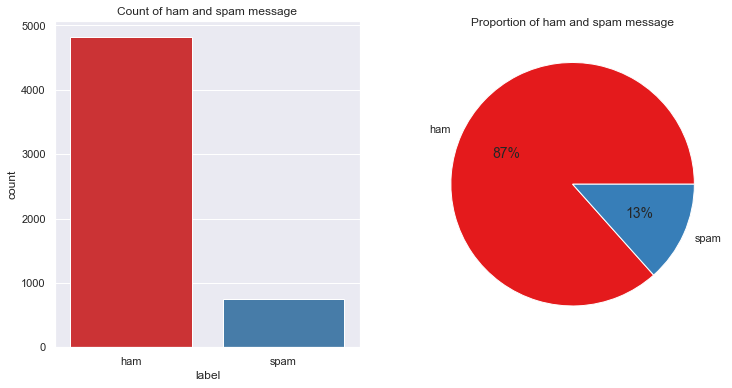

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df,x='label')
plt.title('Count of ham and spam message')
plt.subplot(1, 2, 2);
plt.title('Proportion of ham and spam message')
plt.pie(df[['label']].value_counts(),labels=['ham','spam'],autopct='%.0f%%',colors=sns.color_palette('Set1')[:2]);

* Dataset is imbalance since num of spam messages are less then ham messages

## Feature Engineering

* Handling imbalanced dataset using Oversampling
* Creating new features e.g. word_count, contains_currency_symbol, contains_numbers, etc.

In [11]:
spam_sms = df[df['label']=='spam']

In [12]:
print('Number of Spam records:',spam_sms.shape[0])
print('Number of Ham records: ',df.shape[0]-spam_sms.shape[0])

Number of Spam records: 747
Number of Ham records:  4825


In [13]:
# Oversampling
count = int((df.shape[0]-spam_sms.shape[0])/spam_sms.shape[0])
for i in range(0, count-1):
    df = pd.concat([df, spam_sms])

df.shape

(9307, 2)

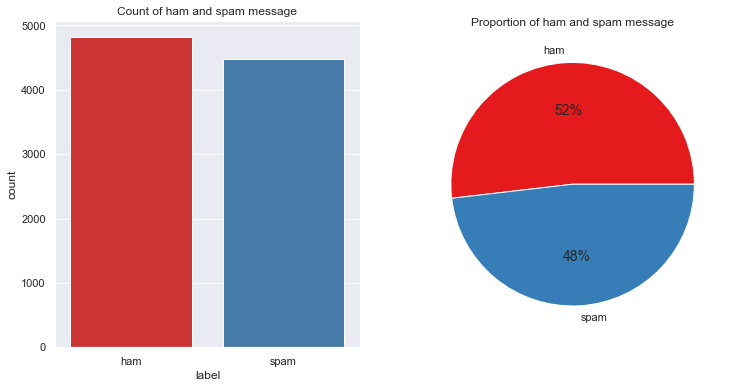

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=df,x='label')
plt.title('Count of ham and spam message')
plt.subplot(1, 2, 2);
plt.title('Proportion of ham and spam message')
plt.pie(df[['label']].value_counts(),labels=['ham','spam'],autopct='%.0f%%',colors=sns.color_palette('Set1')[:2]);

### Adding new column word_count for count of words in each message

In [15]:
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

### Distribution of number of words in each sms

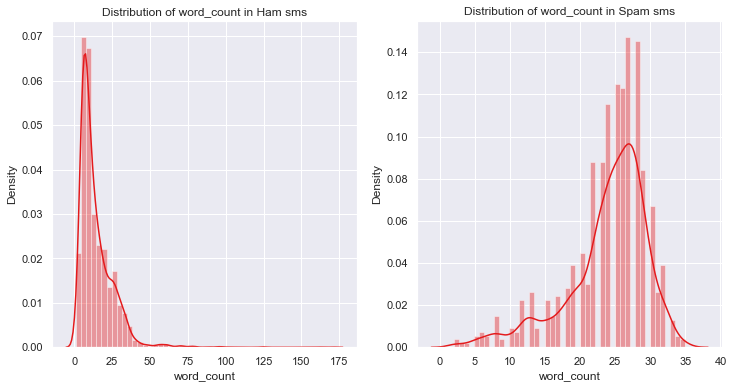

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1);
sns.distplot(a=df[df['label']=='ham'].word_count);
plt.title('Distribution of word_count in Ham sms');

plt.subplot(1, 2, 2);
sns.distplot(a=df[df['label']=='spam'].word_count);
plt.title('Distribution of word_count in Spam sms');



* In ham sms most of the sms contain words in range of 5 - 50 words
* In spam sms most of the sms contain words in range of 20 - 30 words

### Adding column to count currency symbol in sms

In [17]:
def is_currency(txt):
    currency_symbols = ['€', '$', '¥', '£', '₹']
    for i in currency_symbols:
        if i in txt:
            return 1
    return 0

In [18]:
df['currency_symbol'] = df['message'].apply(is_currency)

### Adding column to count currency symbol in sms

In [19]:
def is_number(x):
    for i in x:
        if ord(i)>=48 and ord(i)<=57:
            return 1
    return 0

In [21]:
df['number'] = df['message'].apply(is_number)

### Plot for message with and without number and currency symbol

In [22]:
curr_sym = df[['label','currency_symbol','number']]

In [23]:
curr_sym

,label,currency_symbol,number
0,ham,0,0
1,ham,0,0
2,spam,0,1
3,ham,0,0
4,ham,0,0
...,...,...,...
5537,spam,0,1
5540,spam,1,1
5547,spam,0,1
5566,spam,0,1


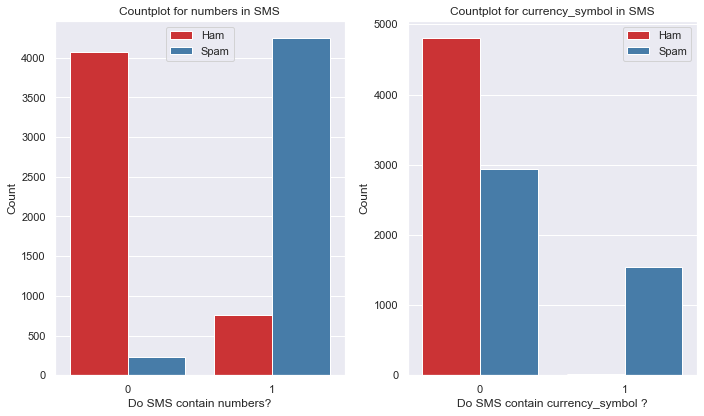

In [24]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
sns.countplot(x='number', data=curr_sym, hue='label')
plt.title('Countplot for numbers in SMS')
plt.xlabel('Do SMS contain numbers?')
plt.ylabel('Count')
plt.legend(labels=['Ham', 'Spam'])
plt.subplot(1, 2, 2)
sns.countplot(x='currency_symbol', data=curr_sym, hue='label')
plt.title('Countplot for currency_symbol in SMS')
plt.xlabel('Do SMS contain currency_symbol ?')
plt.ylabel('Count')
plt.legend(labels=['Ham', 'Spam'])
plt.tight_layout()

* A very few ham SMS contains number
* Most Spam sms contains numbers

---------------------------------
* No ham sms contains currency symbols
* Spam message may or may not contains currency symbol

## Data Cleaning

In [25]:
# Creating a copy of dataset
df_new = df.copy()

### Removing special character and numbers

In [26]:
df_new.reset_index(drop=True,inplace=True)

In [27]:
# function for cleaning text
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)

def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

In [28]:
df_new['message'] = df_new['message'].apply(clean)

In [29]:
df_new['message'] = df_new['message'].apply(is_special)

### Change text to lower case

In [30]:
df_new['message'] = df_new['message'].apply(lambda text:text.lower())

### Removing the stop words

In [31]:
stop_words = set(stopwords.words('english'))
def rem_stopwords(text,stopword_list=stop_words):
    for w in text:
        if w in stopword_list:
            text.replace(w,'')
    return text

In [32]:
df_new['message'] = df_new['message'].apply(rem_stopwords)

###  Lemmatizing the words

In [33]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OMJI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\OMJI\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [34]:
def lemma_word(text):
    lem = WordNetLemmatizer()
    for w in text:
        text.replace(w,lem.lemmatize(w,"v"))
    return text

In [35]:
df_new['lemmatize_message']=df_new['message'].apply(lemma_word)

In [36]:
df_new

,label,message,word_count,currency_symbol,number,lemmatize_message
0,ham,go until jurong point crazy available only ...,20,0,0,go until jurong point crazy available only ...
1,ham,ok lar joking wif u oni,6,0,0,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28,0,1,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say,11,0,0,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives aro...,13,0,0,nah i don t think he goes to usf he lives aro...
...,...,...,...,...,...,...
9302,spam,want explicit sex in 30 secs ring 02073162414...,16,0,1,want explicit sex in 30 secs ring 02073162414...
9303,spam,asked 3mobile if 0870 chatlines inclu in free ...,33,1,1,asked 3mobile if 0870 chatlines inclu in free ...
9304,spam,had your contract mobile 11 mnths latest moto...,28,0,1,had your contract mobile 11 mnths latest moto...
9305,spam,reminder from o2 to get 2 50 pounds free call...,28,0,1,reminder from o2 to get 2 50 pounds free call...


## Data Preprocessing

### Replacing label ham - 0 and spam - 1

In [37]:
df_new['label'] = df_new['label'].map({'ham': 0, 'spam': 1})

### Creating a bag of words model

In [38]:
tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(df_new['lemmatize_message']).toarray()
feature_names = tfidf.get_feature_names()

In [39]:
# Length of features
len(feature_names)

500

### Splitting data input and output values

In [40]:
X = pd.DataFrame(vectors, columns=feature_names)
y = df_new['label']

In [41]:
X

,00,000,03,04,0800,08000839402,08000930705,10,100,1000,...,yeah,year,years,yes,yet,yo,you,your,yours,yr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.278886,0.0,0.0,0.0,0.000000,0.0,0.0
9304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.245579,0.0,0.0,0.0,0.137569,0.0,0.0
9305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.131166,0.0,0.0


In [42]:
y

0       0
1       0
2       1
3       0
4       0
       ..
9302    1
9303    1
9304    1
9305    1
9306    1
Name: label, Length: 9307, dtype: int64

### Split data into Train and Test

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## ML Models Building and Evaluation

### Naive Bayes classifier for multinomial models.

In [44]:
mnb = MultinomialNB()

In [45]:
# Model Training
mnb.fit(X_train,y_train)

MultinomialNB()

### Naive Bayes Model Evaluation

In [46]:

def model_eval(clf, X_train, y_train, X_test, y_test, train_score=True):
    if train_score:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train_score==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

#### Scores

In [47]:
# Train Scores
model_eval(mnb, X_train, y_train, X_test, y_test, train_score=True)

Train Result:
Accuracy Score: 95.72%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.950013     0.965183  0.957152     0.957598      0.957305
recall        0.968443     0.944957  0.957152     0.956700      0.957152
f1-score      0.959139     0.954963  0.957152     0.957051      0.957131
support    3866.000000  3579.000000  0.957152  7445.000000   7445.000000
_______________________________________________
Confusion Matrix: 
 [[3744  122]
 [ 197 3382]]



In [48]:
# Test Scores
model_eval(mnb, X_train, y_train, X_test, y_test, train_score=False)

Test Result:
Accuracy Score: 95.60%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.944276    0.969143  0.955961     0.956709      0.956335
recall       0.971846    0.939092  0.955961     0.955469      0.955961
f1-score     0.957862    0.953881  0.955961     0.955872      0.955931
support    959.000000  903.000000  0.955961  1862.000000   1862.000000
_______________________________________________
Confusion Matrix: 
 [[932  27]
 [ 55 848]]



## Decision Tree Classifier Models

In [49]:
dtc = DecisionTreeClassifier()

In [50]:
# Model Training
dtc.fit(X_train,y_train)

DecisionTreeClassifier()

### Model Evaluation Decision Tree

In [51]:
# Train Scores
model_eval(dtc, X_train, y_train, X_test, y_test, train_score=True)

Train Result:
Accuracy Score: 99.89%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.997935     1.000000  0.998925     0.998967      0.998928
recall        1.000000     0.997765  0.998925     0.998882      0.998925
f1-score      0.998966     0.998881  0.998925     0.998924      0.998925
support    3866.000000  3579.000000  0.998925  7445.000000   7445.000000
_______________________________________________
Confusion Matrix: 
 [[3866    0]
 [   8 3571]]



In [52]:
# Test Scores
model_eval(dtc, X_train, y_train, X_test, y_test, train_score=False)

Test Result:
Accuracy Score: 98.07%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.995704    0.965628  0.980666     0.980666      0.981118
recall       0.966632    0.995570  0.980666     0.981101      0.980666
f1-score     0.980952    0.980371  0.980666     0.980662      0.980670
support    959.000000  903.000000  0.980666  1862.000000   1862.000000
_______________________________________________
Confusion Matrix: 
 [[927  32]
 [  4 899]]



* Decision Tree is little Overfitting 

## Random Forest Classifier 

In [53]:
rfc = RandomForestClassifier(n_estimators=10)

In [54]:
# Training Model
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

## Random Forest Classifier Model Evaluation 

In [55]:
# Train Scores
model_eval(rfc, X_train, y_train, X_test, y_test, train_score=True)

Train Result:
Accuracy Score: 99.89%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.997935     1.000000  0.998925     0.998967      0.998928
recall        1.000000     0.997765  0.998925     0.998882      0.998925
f1-score      0.998966     0.998881  0.998925     0.998924      0.998925
support    3866.000000  3579.000000  0.998925  7445.000000   7445.000000
_______________________________________________
Confusion Matrix: 
 [[3866    0]
 [   8 3571]]



In [56]:
# Test Scores
model_eval(rfc, X_train, y_train, X_test, y_test, train_score=False)

Test Result:
Accuracy Score: 99.68%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.995838    0.997780  0.996778     0.996809      0.996780
recall       0.997914    0.995570  0.996778     0.996742      0.996778
f1-score     0.996875    0.996674  0.996778     0.996775      0.996778
support    959.000000  903.000000  0.996778  1862.000000   1862.000000
_______________________________________________
Confusion Matrix: 
 [[957   2]
 [  4 899]]



In [57]:
def comp_models(models,X_test,y_test):
    scores = {'Model Name':[],'Accuracy':[]}
    for name,model in models:
        pred = model.predict(X_test)
        scores['Model Name'].append(str(name)) 
        scores['Accuracy'].append(accuracy_score(y_test, pred)*100)
        scores_df = pd.DataFrame(scores)
        sns.barplot(data=scores_df,x='Model Name',y='Accuracy',)
        plt.title('Models Accuracy Comparison')

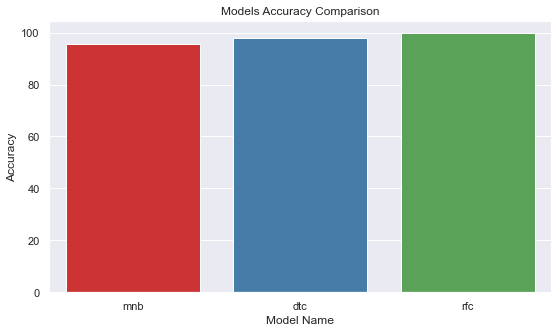

In [58]:
models =[('mnb',mnb),('dtc',dtc),('rfc',rfc)]
comp_models(models,X_test,y_test)

## Voting Classifier with Decision Tree and Random Forest Classifier

In [59]:
vc = VotingClassifier([('decision_tree', dtc), ('random_forest_classifier', rfc)], weights=[0.8,2])

In [60]:
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('decision_tree', DecisionTreeClassifier()),
                             ('random_forest_classifier',
                              RandomForestClassifier(n_estimators=10))],
                 weights=[0.8, 2])

### Voting Classifier Evaluation

In [61]:
# Train Scores
model_eval(vc, X_train, y_train, X_test, y_test, train_score=True)

Train Result:
Accuracy Score: 99.89%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.997935     1.000000  0.998925     0.998967      0.998928
recall        1.000000     0.997765  0.998925     0.998882      0.998925
f1-score      0.998966     0.998881  0.998925     0.998924      0.998925
support    3866.000000  3579.000000  0.998925  7445.000000   7445.000000
_______________________________________________
Confusion Matrix: 
 [[3866    0]
 [   8 3571]]



In [62]:
# Test Scores
model_eval(vc, X_train, y_train, X_test, y_test, train_score=False)

Test Result:
Accuracy Score: 99.73%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.995842    0.998889  0.997315     0.997365      0.997320
recall       0.998957    0.995570  0.997315     0.997264      0.997315
f1-score     0.997397    0.997227  0.997315     0.997312      0.997315
support    959.000000  903.000000  0.997315  1862.000000   1862.000000
_______________________________________________
Confusion Matrix: 
 [[958   1]
 [  4 899]]



### Comparing Models

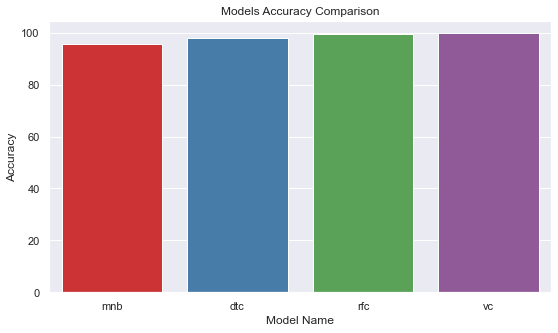

In [63]:
models =[('mnb',mnb),('dtc',dtc),('rfc',rfc),('vc',vc)]
comp_models(models,X_test,y_test)

* As we see a little improvemet with voting classifier
* So we will be using voting classifier for prediction

## Prediction with single SMS

In [64]:
from sklearn.pipeline import Pipeline

In [65]:
def predict_spam(sms,model=vc):
    message =  re.sub(pattern='[^a-zA-Z]',repl=' ', string = sms)
    message = message.lower()
    message_words = [word for word in message if not word in set(stopwords.words('english'))]
    message_words = [WordNetLemmatizer.lemmatize(word,"v") for word in message_words]
    message = ' '.join(message_words)
    tfidf_bow = tfidf.transform([message]).toarray()
    prediction = model.predict(tfidf_bow)
    if prediction == 0:
        return 'Ham'
    else:
        return 'Spam'
    


In [66]:
print(predict_spam(df['message'][1]))

Ham
